In [1]:
!pip install -q tokenizers


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


## Importing Libraries

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention
from tokenizers import ByteLevelBPETokenizer, AddedToken

D0707 12:44:05.832498410      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0707 12:44:05.832521815      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0707 12:44:05.832525459      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0707 12:44:05.832528287      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0707 12:44:05.832530883      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0707 12:44:05.832533812      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0707 12:44:05.832536497      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0707 12:44:05.

## Use a TPU / Multiple GPUs if possible

In [3]:
# Detect and init the TPU if available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU:", tpu.master() or "local")
except ValueError:
    # If a TPU is not available, check for a GPU
    gpus = tf.config.list_physical_devices("GPU")

    if gpus:
        strategy = tf.distribute.MirroredStrategy()
        
        gpu_len = len(gpus)
        print(f"Running on", gpu_len, f"GPU{'s' if gpu_len != 1 else ''}")
    else:
        strategy = tf.distribute.OneDeviceStrategy("CPU")
        print("Running on CPU")

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

## Loading the data

In [4]:
df = pd.read_csv("/kaggle/input/mcdonalds-store-reviews/McDonald_s_Reviews.csv", encoding="latin-1")

In [5]:
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


## Preprocessing

In [6]:
df["rating"] = df["rating"].str.extract(r"(\d+)", expand=False).astype(int)

In [7]:
df["review"] = df["review"].str.encode("ascii", "ignore").str.decode("utf-8")

In [8]:
review_mapping = {1: 0, 2: 0, 3: None, 4: 1, 5: 1}
df["rating"] = df["rating"].map(review_mapping)

# Drop rows with review value equal to 3
df = df.dropna(subset=["rating"])

In [9]:
df = df[["review", "rating"]]

In [10]:
df.head()

,review,rating
0,Why does it look like someone spit on my food?...,0.0
1,It'd McDonalds. It is what it is as far as the...,1.0
2,Made a mobile order got to the speaker and che...,0.0
3,My mc. Crispy chicken sandwich was customer s...,1.0
4,"I repeat my order 3 times in the drive thru, a...",0.0


### Text tokenization using Tokenizers

In [11]:
# Instantiate the tokenizer
sequence_length = 512
vocab_size = 10_000

tokenizer = ByteLevelBPETokenizer()

In [12]:
tokenizer.train_from_iterator(
    df["review"], vocab_size=vocab_size, special_tokens=["<pad>"])

In [13]:
# Tokenize the sequences
encode_batch = tokenizer.encode_batch

df["encoded_sequence"] = [i.ids for i in encode_batch(df["review"])]

In [14]:
max(df["encoded_sequence"].apply(len))

719

In [15]:
# Pad the sequences to sequence_length
df["padded_sequence"] = tf.keras.preprocessing.sequence.pad_sequences(
    df["encoded_sequence"], maxlen=sequence_length, padding="post", truncating="post").tolist()

In [16]:
df.head(5)

,review,rating,encoded_sequence,padded_sequence
0,Why does it look like someone spit on my food?...,0.0,"[4056, 944, 316, 1230, 465, 1116, 4358, 319, 3...","[4056, 944, 316, 1230, 465, 1116, 4358, 319, 3..."
1,It'd McDonalds. It is what it is as far as the...,1.0,"[623, 1465, 577, 14, 588, 314, 559, 316, 314, ...","[623, 1465, 577, 14, 588, 314, 559, 316, 314, ..."
2,Made a mobile order got to the speaker and che...,0.0,"[5806, 258, 1461, 320, 519, 276, 263, 2054, 27...","[5806, 258, 1461, 320, 519, 276, 263, 2054, 27..."
3,My mc. Crispy chicken sandwich was customer s...,1.0,"[1183, 734, 14, 7073, 845, 936, 301, 221, 566,...","[1183, 734, 14, 7073, 845, 936, 301, 221, 566,..."
4,"I repeat my order 3 times in the drive thru, a...",0.0,"[41, 3040, 344, 320, 582, 751, 309, 263, 423, ...","[41, 3040, 344, 320, 582, 751, 309, 263, 423, ..."


## Transformer model architechure

The Transformer model architechure was introduced by Vaswani et al. in the paper "Attention is All You Need" in 2017. It is a type of deep learning model designed primarily for sequence-to-sequence tasks, such as machine translation and text summarization, however it is widely used for classification (Think BERT). The main innovation of the Transformer model is its reliance on self-attention mechanisms instead of recurrent or convolutional layers.

The Transformer architecture consists of two major components: the encoder and the decoder. Both the encoder and the decoder are composed of a stack of identical layers, and each layer contains two main sublayers: a multi-head self-attention mechanism and a position-wise feed-forward network. In our case, we remove the decoder as we are doing classification work and not sequence-to-sequence tasks like autoregressive language modeling or text generation.


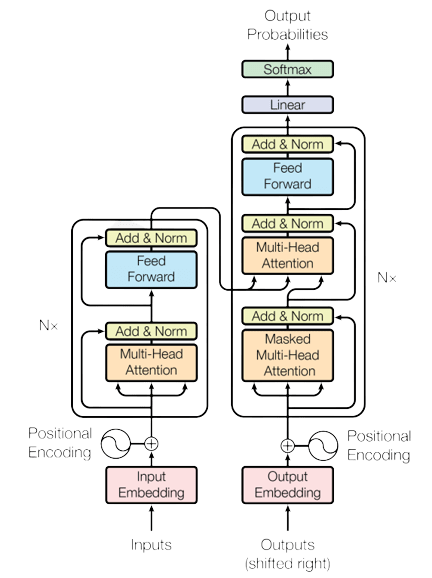

In [17]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BaseAttention, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [18]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x
        )

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

### Positional encoding

In [19]:
def positional_encoding(length, depth):
    depth = depth / 2

    positions = np.arange(length)[:, np.newaxis]  # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)

    angle_rates = 1 / (10000 ** depths)  # (1, depth)
    angle_rads = positions * angle_rates  # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1
    )

    return tf.cast(pos_encoding, dtype=tf.float32)

### Positional embedding

In [20]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super(PositionalEmbedding, self).__init__()
        
        self.d_model = d_model
        
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)

        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[tf.newaxis, :seq_len, :]

        return x

### Feed forward

In [21]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super(FeedForward, self).__init__()

        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation="gelu"),
            tf.keras.layers.Dense(d_model),
        ])

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        ffn_output = self.ffn(x)
        ffn_output = self.dropout(ffn_output)

        x = self.add([x, ffn_output])
        x = self.layer_norm(x)

        return x

### Encoder layer

In [22]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)

        return x

### Encoder

In [23]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                 dff, vocab_size, dropout_rate=0.1):

        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)  # (batch_size, seq_len, d_model)
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # (batch_size, seq_len, d_model)

### Transformer

In [24]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
                 input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

    def call(self, inputs):
        logits = self.encoder(inputs)

        try:
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

## Creating the transformer model
### Model hyperparameters

In [25]:
vocab_size = tokenizer.get_vocab_size()
num_layers = 4
d_model = 256
dff = 300
num_heads = 8
dropout_rate = 0.1

### Learning rate schedule

In [26]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=4e-4,
    decay_steps=30,
    decay_rate=0.9
)

### Model definition

In [27]:
with strategy.scope():
    inputs = tf.keras.Input(shape=(None,))

    transformer = Transformer(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        input_vocab_size=vocab_size,
        target_vocab_size=None,
        dropout_rate=dropout_rate
    )

    x = transformer(inputs)

    classif_layers = [
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.LayerNormalization(),

        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
        tf.keras.layers.LayerNormalization(),

        tf.keras.layers.Dense(128, activation="relu",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.20)
    ]

    for layer in classif_layers:
        x = layer(x)

    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=tf.keras.optimizers.Adam(
                      learning_rate=lr_schedule, beta_1=0.9, beta_2=0.98, epsilon=1e-9),
                  metrics=["accuracy"])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 transformer (Transformer)   (None, None, 256)         11594928  
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        394240    
 l)                                                              
                                                                 
 layer_normalization_8 (Laye  (None, None, 256)        512       
 rNormalization)                                                 
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                             

## Data preperation
Here we convert all input data into NumPy arrays and prepare said arrays for the model. We are aiming for the following:
  - Optimizing memory usage
  - Improving data access efficiency
  - Ensuring the data remains unmodified during the execution of subsequent code.
  
To achieve the above, we make the arrays contiguous, meaning the elements are stored in a continous block of memory, and we set the writeable flag to False, preventing accidental modifications to the data.

In [29]:
# Splitting the dataframe into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

X_train = np.array(train_df["padded_sequence"].tolist())
X_train = np.ascontiguousarray(X_train)
X_train.flags.writeable = False

y_train = tf.expand_dims(train_df["rating"].tolist(), axis=1)
y_train = np.ascontiguousarray(y_train)
y_train.flags.writeable = False

X_test = np.array(test_df["padded_sequence"].tolist())
X_test = np.ascontiguousarray(X_test)
X_test.flags.writeable = False

y_test = tf.expand_dims(test_df["rating"].tolist(), axis=1)
y_test = np.ascontiguousarray(y_test)
y_test.flags.writeable = False

### Using a `tf.Data` pipeline

In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(
    strategy.num_replicas_in_sync * 128
).cache().prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(
    strategy.num_replicas_in_sync * 128
).cache().prefetch(AUTOTUNE)

## Model training

In [31]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=2, restore_best_weights=True)]
)

Epoch 1/32


2023-07-07 12:44:56.037917: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-07 12:44:56.705288: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


23/23 [==============================] - ETA: 0s - loss: 2.2637 - accuracy: 0.6641

2023-07-07 12:46:34.829383: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-07 12:46:35.086359: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


23/23 [==============================] - 132s 4s/step - loss: 2.2637 - accuracy: 0.6641 - val_loss: 2.1147 - val_accuracy: 0.6980
Epoch 2/32
23/23 [==============================] - 50s 2s/step - loss: 1.7925 - accuracy: 0.8543 - val_loss: 1.7629 - val_accuracy: 0.8634
Epoch 3/32
23/23 [==============================] - 50s 2s/step - loss: 1.4921 - accuracy: 0.9228 - val_loss: 1.5127 - val_accuracy: 0.9094
Epoch 4/32
23/23 [==============================] - 50s 2s/step - loss: 1.2942 - accuracy: 0.9454 - val_loss: 1.4002 - val_accuracy: 0.8950
Epoch 5/32
23/23 [==============================] - 50s 2s/step - loss: 1.1305 - accuracy: 0.9559 - val_loss: 1.3189 - val_accuracy: 0.8791
Epoch 6/32
23/23 [==============================] - 50s 2s/step - loss: 0.9828 - accuracy: 0.9671 - val_loss: 1.1335 - val_accuracy: 0.8961
Epoch 7/32
23/23 [==============================] - 50s 2s/step - loss: 0.8697 - accuracy: 0.9693 - val_loss: 0.9856 - val_accuracy: 0.9022
Epoch 8/32
23/23 [============

## Model evaluataion

In [32]:
model.evaluate(test_ds)

6/6 [==============================] - 2s 195ms/step - loss: 0.6510 - accuracy: 0.9099


[0.6509942412376404, 0.909902036190033]

## Plotting the loss, value loss, accuracy and value accuracy

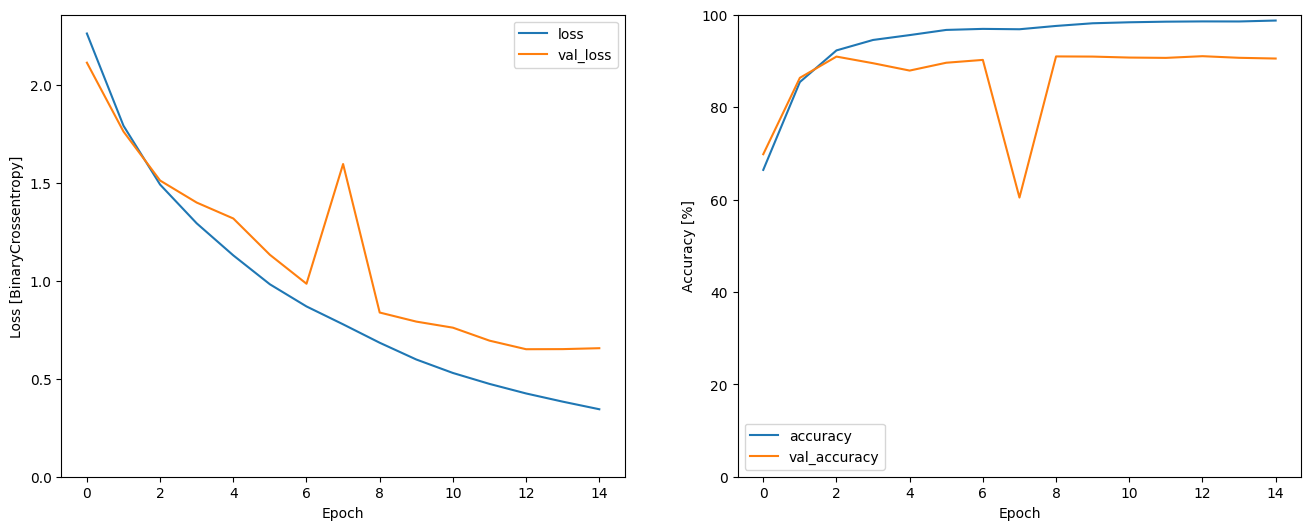

In [33]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics["loss"], metrics["val_loss"])
plt.legend(["loss", "val_loss"])
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch")
plt.ylabel("Loss [BinaryCrossentropy]")

plt.subplot(1, 2, 2)
plt.plot(history.epoch, 100 *
         np.array(metrics["accuracy"]), 100 * np.array(metrics["val_accuracy"]))
plt.legend(["accuracy", "val_accuracy"])
plt.ylim([0, 100])
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.show()

## Saving the model and tokenizer

In [34]:
# Save the model
model.save("/kaggle/working/model.h5")

# Save the model weights
model.save_weights("/kaggle/working/model_weights.h5")

# Save the tokenizer
tokenizer.save("/kaggle/working/tokenizer.bpe")

## Creating an end-to-end version

It's no fun running our model in the current state: having to tokenize the text, pad it, call the model and then work out labels. Let's create an easy-to-use end-to-end version with our trained model and tokenizer.

In [35]:
class SentimentAnalysisModel():
    def __init__(self, model, tokenizer, sequence_length):
        self.model = model
        self.tokenizer = tokenizer
        self.sequence_length = sequence_length

    def __call__(self, x):
        if isinstance(x, str):
            x = [x]
        
        encode_batch = self.tokenizer.encode_batch
        x = [i.ids for i in encode_batch(x)]
        
        x = tf.keras.preprocessing.sequence.pad_sequences(
            x, maxlen=self.sequence_length, padding="post", truncating="post")

        pred = self.model(x, training=False)

        res = np.zeros((len(pred),), dtype=object)

        for i, p in enumerate(pred):
            label = "POSITIVE" if tf.keras.backend.greater(
                p[0], 0.5) else "NEGATIVE"
            confidence = tf.keras.backend.abs(p[0] - 0.5) * 2

            res[i] = {
                "label": label,
                "confidence": confidence.numpy()
            }

        return res


export = SentimentAnalysisModel(model, tokenizer, sequence_length)

with open("/kaggle/working/model_end2end", "wb") as f:
    pickle.dump(export, f)

In [36]:
custom_objs = {"Transformer": Transformer}

with tf.keras.utils.custom_object_scope(custom_objs), open("/kaggle/working/model_end2end", "rb") as f:
    loaded_model = pickle.load(f)

## Testing the end-to-end model

In [37]:
export(["This is a great product", "This is a horrible product"])

array([{'label': 'POSITIVE', 'confidence': 0.95718706},
       {'label': 'NEGATIVE', 'confidence': 0.9593007}], dtype=object)

In [38]:
(export(["This is a great product", "This is a horrible product"]) == loaded_model(
    ["This is a great product", "This is a horrible product"])).all()

True

--------------------------